```{glue:} glued_fig
```
# Cell nuclei detection using StarDist

In this notebook, we will use StarDist to detect cell nuclei in an image extracted from a public dataset of histopathology images.

[StarDist](https://github.com/stardist/stardist) is a deep-learning based Python library used for segmenting star-convex objects, such as cell nuclei, in 2D and 3D images. It is also available as plugins for [ImageJ](https://imagej.net/plugins/stardist), [Napari](https://github.com/stardist/stardist-napari), and [Qupath](https://qupath.readthedocs.io/en/0.3/docs/advanced/stardist.html).


In [1]:
from myst_nb import glue  # To paste the figure output at the top of the notebook

## Setup

Check that you have the `stardist` package installed (`pip install stardist`).

In [2]:
from stardist.models import StarDist2D

2024-06-15 22:06:50.325875: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 22:06:50.328073: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 22:06:50.359529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 22:06:50.359561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 22:06:50.360695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Download and read the image

The image we'll use in this tutorial is available for download on [Zenodo](https://zenodo.org/record/8099852) (`deepslide.png`). This image is part of the [DeepSlides](https://zenodo.org/record/1184621) public dataset.

In the cell below, we download this image from Zenodo and read it into a Numpy array.

In [3]:
from shared_data import DATASET  # This dataset has a reference to the image on Zenodo.
from skimage.io import imread

image_file = DATASET.fetch("deepslide.png")

image = imread(image_file)

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape: (513, 513, 3) and data type uint8
Intensity range: [3 - 245]


## Visualize the image using matplotlib

Let's have a quick look at our example image.

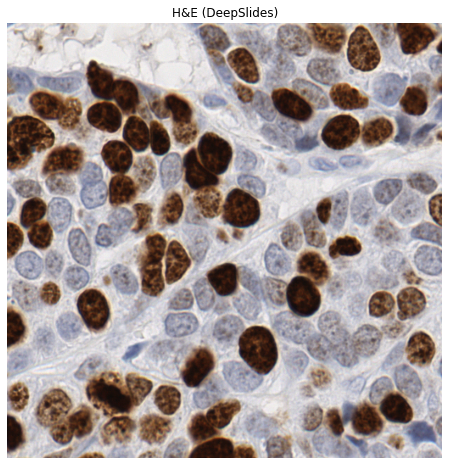

In [4]:
import matplotlib.pyplot as plt

fig_mpl, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
plt.title("H&E (DeepSlides)")
plt.axis('off')  # Hide axes ticks
plt.show()

## Normalize the image intensity

Let's rescale our image to the range 0-1. By doing so, it is also converted to an array of data type `float`.

In [5]:
from skimage.exposure import rescale_intensity

image_normed = rescale_intensity(image, out_range=(0, 1))

print(f'Intensity range: [{image_normed.min()} - {image_normed.max()}]')
print(f'Array type: {image_normed.dtype}')

Intensity range: [0.0 - 1.0]
Array type: float64


## Initialize a pre-trained StarDist model

The StarDist developers provide a few pre-trained models that may already be applied to suitable images.

Here, we will use the *Versatile (H&E nuclei)* model that was trained on images from the MoNuSeg 2018 training data and the TNBC dataset from Naylor et al. (2018).

In [6]:
model = StarDist2D.from_pretrained("2D_versatile_he")

model

Found model '2D_versatile_he' for 'StarDist2D'.


2024-06-15 22:06:55.945661: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-15 22:06:55.945690: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: vilthuril
2024-06-15 22:06:55.945694: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: vilthuril
2024-06-15 22:06:55.946012: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.67.0
2024-06-15 22:06:55.946024: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.67.0
2024-06-15 22:06:55.946026: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.67.0


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[512, 512], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.1], train_class_weights=(1, 1), train_epochs=200, train_steps_per_epoch=200, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=3, train_tensorboard=True, train_r

## Run the model

We use the `predict_instances` method of the model to generate a segmenation mask (`labels`) and a representation of the cell nuclei as polygons (`polys`).

In [7]:
labels, polys = model.predict_instances(
    image_normed,  # The image must be normalized
    axes="YXC",
    prob_thresh=0.5,  # Detection probability threshold
    nms_thresh=0.1,  # Remove detections overlapping by more than this threshold
    scale=1,  # Higher values are suitable for lower resolution data
    return_labels=True,
)

# We also get detection probabilities
probabilities = list(polys["prob"])

n_detections = len(probabilities)

print(f'{n_detections} cells detected.')

119 cells detected.


## Visualize the segmentation using `label2rgb`

The `label2rgb` function from Scikit-image assigns a random color to each object in a labeled segmentation mask. This is useful for visualization!

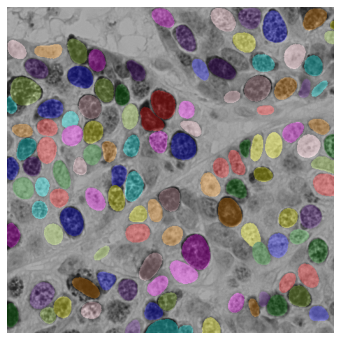

In [8]:
from skimage.color import label2rgb

fig, ax = plt.subplots(figsize=(12, 6))
rgb_composite = label2rgb(labels, image=image, bg_label=0)
ax.imshow(rgb_composite)
plt.axis('off')
plt.show()

## Visualize the segmentation using `Pillow`

In the cell below, we use the `Pillow` library to overlay a segmentation mask on top of the image. The shade of green represents the detection probability.

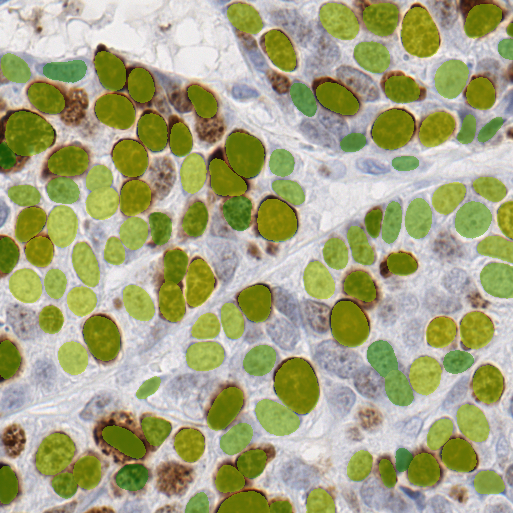

In [137]:
from PIL import Image, ImageOps
import numpy as np

probabilities.insert(0, 0)

parametric_image = np.take(probabilities, labels)

image_ = Image.fromarray(image).convert("RGBA")

mask = Image.fromarray((labels == 0).astype('uint8')).convert("L")

alpha_mask = mask.point(lambda p: 128 if p == 0 else 0)

colorized_mask = ImageOps.colorize(
    Image.fromarray((parametric_image * 255).astype(np.uint8)).convert("L"), 
    black="green", 
    white="yellow", 
    blackpoint=128,
    whitepoint=255,
).convert("RGBA")

colorized_mask.putalpha(alpha_mask)

composite_image = Image.alpha_composite(image_, colorized_mask)

In [ ]:
glue('glued_fig', composite_image, display=False);

```{glue:} glued_fig
```

## Conclusion

In this notebook, we have used `StarDist` to segment cell nuclei in an image from the DeepSlides dataset.